In [1]:
!pip install arff
!pip install optuna

  Preparing metadata (setup.py) ... done
  Created wheel for arff: filename=arff-0.9-py3-none-any.whl size=4950 sha256=439aaea544ad7eed059105741c15ecd512dc319c77b51505fe304a96f9354ea0
  Stored in directory: /root/.cache/pip/wheels/0c/39/12/4d8ff491018bce2dd9cc6034298f27399c7f4fd4063187f7be
Successfully built arff
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 12.8 MB/s eta 0:00:00


In [3]:
import pandas as pd
import arff
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, TweedieRegressor
import optuna
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error
import seaborn as sns

Load Data

In [4]:
data_freq = arff.load('freMTPL2freq.arff')
df_freq = pd.DataFrame(data_freq, columns=["IDpol", "ClaimNb", "Exposure", "Area", "VehPower", "VehAge", "DrivAge", "BonusMalus", "VehBrand", "VehGas", "Density", "Region"])
data_sev = arff.load('freMTPL2sev.arff')
df_sev = pd.DataFrame(data_sev, columns=["IDpol", "ClaimAmount"])
del data_freq, data_sev

In [5]:
# First sum up the "ClaimAmount" with duplicate entries of "IDpol".
df_sev = df_sev.groupby("IDpol", as_index=False).agg({'ClaimAmount': 'sum'})

# There are some nan features in df_freq with some "IDpol" in df_freq, which is directly cleaned,
merged_df = pd.merge(df_freq, df_sev, on="IDpol", how="outer")
merged_df["ClaimAmount"] = merged_df["ClaimAmount"].fillna(0)
merged_df = merged_df.dropna(how="any")
merged_df = merged_df.drop(['IDpol','ClaimNb'], axis = 1)

In [6]:
# Hyper-parameters
random_seed = 35
np.random.seed(random_seed)
input_standardization = True
output_standardization = False
feature_visualization = True


Feature Preprocessing

In [7]:
# Define the column transformer for handling different types of data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', preprocessing.MinMaxScaler(), [col for col in merged_df.columns if merged_df[col].dtype in [np.float64, np.float32] and col not in ['ClaimAmount', 'Exposure', 'IDpol', 'ClaimNb']]),
        ('cat', preprocessing.OneHotEncoder(handle_unknown='ignore'), [col for col in merged_df.columns if merged_df[col].dtype == 'object']),
    ],
    remainder='drop'
)

# Exclude 'ClaimAmount' and 'Exposure' from any transformation if output_standardization is applied
if output_standardization:
    output_scaler = preprocessing.MinMaxScaler()
claim_amount = merged_df.pop('ClaimAmount') / merged_df.pop('Exposure')  # Separate and transform this column separately

# Create a processing pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    # ('output_scaler', output_scaler) if output_standardization else ('dummy', 'passthrough')
])

# Fit and transform the training data
X = pipeline.fit_transform(merged_df)
y = claim_amount


# If there's output standardization, fit and transform 'ClaimAmount' specifically
if output_standardization:
    y = output_scaler.fit_transform(y.values.reshape(-1, 1))


# Convert sparse Matrice representation of one-hot encoding to full representation
X = X.toarray()
print(X[0], X[0].shape)

[0.09090909 0.         0.45121951 0.         0.04503871 0.
 0.         0.         1.         0.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.        ] (46,)


Define Optuna Objective Function for hyperparameter optimization

In [8]:
def objective(trial, X, y):
    # Suggest values for the hyperparameters
    power = trial.suggest_float('power', 1, 2)
    alpha = trial.suggest_float('alpha', 1e-3, 10.0, log=True)  # Regularization strength
    solver = trial.suggest_categorical('solver', ['lbfgs', 'newton-cholesky'])
    # Create a model with suggested hyperparameters
    model = TweedieRegressor(power=power, alpha=alpha, solver=solver, max_iter= 300)
    # Perform 5-fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=random_seed)
    scores = cross_val_score(model, X, y, cv=kf, scoring=make_scorer(mean_squared_error))
    # Compute RMSE from scores
    rmse = (scores.mean()) ** 0.5
    return rmse

def objective_wrapper(trial):
    return objective(trial, X, y)

Call Optuna for Hyper-parameter Optimization
Assign the incumbent setting to the model

In [9]:
study = optuna.create_study(direction='minimize')
study.optimize(objective_wrapper, n_trials=10)

# Best trial result
print(f"Best trial: {study.best_trial.value}")
print(f"Best parameters: {study.best_trial.params}")
best_params = study.best_params.copy()

model = TweedieRegressor(**best_params)
model.fit(X,y)

[I 2024-05-01 21:36:01,811] A new study created in memory with name: no-name-2539cfcd-eb11-48e8-8c4d-0e1af012bf80
[I 2024-05-01 21:37:35,761] Trial 0 finished with value: 36820.537207231544 and parameters: {'power': 1.0499725434550211, 'alpha': 0.04515810515320362, 'solver': 'lbfgs'}. Best is trial 0 with value: 36820.537207231544.


Best trial: 36820.537207231544
Best parameters: {'power': 1.0499725434550211, 'alpha': 0.04515810515320362, 'solver': 'lbfgs'}


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_glm/glm.py:284: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


TweedieRegressor(alpha=0.04515810515320362, power=1.0499725434550211)

Visualize the feature weight

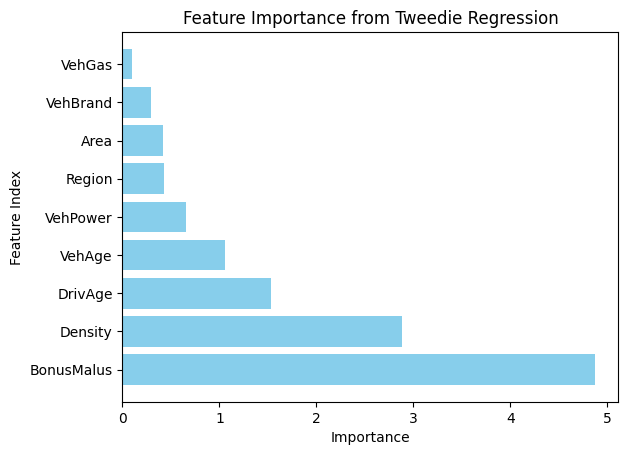

In [10]:
# Get feature names from the column transformer
feature_names = preprocessor.get_feature_names_out()
# print("New Feature Names:", feature_names)

# Plot feature importance
plt.figure()
# plt.bar(range(len(feature_importances)), feature_importances, alpha=0.7)

# Step to categorize and average gradients
feature_groups = {}
for name, weight in zip(feature_names, model.coef_):
    # Parse the feature name to find the base feature (before one-hot encoding)
    if '__' in name:
        base_name = name.split('__')[1].split('_')[0]
        if base_name not in feature_groups:
            feature_groups[base_name] = []
        feature_groups[base_name].append(abs(weight))

# Calculating the mean gradient for each original feature
mean_weights = {feature: np.mean(weight)  for feature, weight in feature_groups.items()}

# Sorting for better visualization
sorted_features = sorted(mean_weights, key=mean_weights.get, reverse=True)
sorted_importances = [mean_weights[feature] for feature in sorted_features]


plt.barh(sorted_features, sorted_importances, color='skyblue')
plt.ylabel('Feature Index')
plt.xlabel('Importance')
plt.title('Feature Importance from Tweedie Regression')
plt.show()